# ISIC 2024 Skin Cancer Detection with 3D-TBP | Kaggle
Competition: https://www.kaggle.com/competitions/isic-2024-challenge

In [1]:
# Mount your Google Drive files Following code make mount your google drive
# By using Google Drive, you ensure that your data is persistently stored and accessible across different Colab sessions.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [113]:
# Upload the kaggle.json file
from google.colab import files
files.upload()

{}

In [ ]:
# Install kaggle API client
! pip install -q kaggle
#  kaggle API client expects the file to be in ~/.kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c isic-2024-challenge

 99% 1.98G/2.00G [00:25<00:00, 145MB/s]
100% 2.00G/2.00G [00:25<00:00, 85.5MB/s]


In [ ]:
! cp -r /content/isic-2024-challenge.zip /content/gdrive/MyDrive/

In [ ]:
! unzip gdrive/MyDrive/ISIC-2024-Challenge/isic-2024-challenge.zip -d gdrive/MyDrive/ISIC-2024-Challenge/

Streaming output truncated to the last 5000 lines.
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874656.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874659.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874663.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874742.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874751.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874803.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874805.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874832.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874878.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874897.jpg  
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-image/image/ISIC_9874925.jpg  
  inflating: g

In [6]:
! unzip gdrive/MyDrive/ISIC-2024-Challenge/isic-2024-challenge.zip train-metadata.csv -d gdrive/MyDrive/ISIC-2024-Challenge/

Archive:  gdrive/MyDrive/ISIC-2024-Challenge/isic-2024-challenge.zip
  inflating: gdrive/MyDrive/ISIC-2024-Challenge/train-metadata.csv  


## 1. Introduction

fill later with detail

- Train a binary classifier to predict whether an image is malignant or benign.

## 2. Libraries

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import random
import h5py

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Misc
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# Dataset
train_metadata_path = "gdrive/MyDrive/ISIC-2024-Challenge/train-metadata.csv"
train_img_path = "gdrive/MyDrive/ISIC-2024-Challenge/train-image.hdf5"
train_metadata = pd.read_csv(train_metadata_path, dtype={'iddx_5': str, 'mel_mitotic_index': str})

test_metadata_path = "gdrive/MyDrive/ISIC-2024-Challenge/test-metadata.csv"
test_img_path = "gdrive/MyDrive/ISIC-2024-Challenge/test-image.hdf5"
test_metadata = pd.read_csv(test_metadata_path, dtype={'iddx_5': str, 'mel_mitotic_index': str})

In [4]:
# Torch version
import torch
print(torch.__version__)

2.3.1+cu121


In [5]:
# Device (Google Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Hardware accelator: {device}")

Hardware accelator: cpu


## 3. Dataset
Among the most employed initial diagnostic methods is the ABCDE criteria [3,6,7], which are described in Table 1. Nevertheless, while this simple, noninvasive, and expertise-based observational approach often leads to an accurate diagnosis of between **60** and **90% of malignant tumors** [3], there are scenarios where the certainty of cancer’s presence can only be ascertained through a biopsy.

Citation: https://www.mdpi.com/2075-4418/14/4/454

In [6]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [7]:
test_metadata.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [9]:
# Extremely unbalanced dataset!

print(f"Benign class: {len(train_metadata.loc[train_metadata['target']==1])} patients")
print(f"Malignant class: {len(train_metadata.loc[train_metadata['target']==0])} patients")

Benign class: 393 patients
Malignant class: 400666 patients


| Criteria | Indicates | Description |
| --- | --- | --- |
| A | Asymmetry | The majority of illustrated melanomas exhibit an imbalance in their features |
| B | Border | The borders of melanomas are usually uneven and may have irregular or scalloped edges |
| C | Color | The presence of multiple colors within a melanoma is a warning sign |
| D | Diameter | Melanomas tend to be larger, approximately the size of an eraser or around 6 mm in diameter or larger |
| E | Evolution | This considers any alteration in the shape, size, color, or elevation of a skin spot as a warning sign of melanoma |

In [10]:
# train_metadata.info()

## 4. Exploratory Data Analysis

In [11]:
train_metadata.sex = train_metadata.sex.replace(["female","male"], [0,1]).astype("Int8")

# Mean Encoding https://www.geeksforgeeks.org/mean-encoding-machine-learning/
mean = train_metadata.groupby("anatom_site_general")["target"].mean()
train_metadata["anatom_site_mean"] = train_metadata["anatom_site_general"].map(mean)

In [12]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,anatom_site_mean
0,ISIC_0015670,0,IP_1235828,60.0,1,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,0.000709
1,ISIC_0015845,0,IP_8170065,60.0,1,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0.006475
2,ISIC_0015864,0,IP_6724798,60.0,1,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0.000845
3,ISIC_0015902,0,IP_4111386,65.0,1,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,0.000934
4,ISIC_0024200,0,IP_8313778,55.0,1,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0.000934


In [13]:
# Remove columns had very little warm zones, if any at all.
feats = ['target', 'tbp_lv_A','tbp_lv_Aext',
         'tbp_lv_B', 'tbp_lv_Bext','tbp_lv_C','tbp_lv_Cext','tbp_lv_L','tbp_lv_Lext',
         'tbp_lv_areaMM2','tbp_lv_area_perim_ratio','tbp_lv_color_std_mean','tbp_lv_deltaA','tbp_lv_deltaB',
         'tbp_lv_deltaL','tbp_lv_deltaLB','tbp_lv_deltaLBnorm','tbp_lv_minorAxisMM',
         'tbp_lv_nevi_confidence','tbp_lv_norm_border','tbp_lv_norm_color','tbp_lv_perimeterMM','tbp_lv_radial_color_std_max',
         'tbp_lv_stdL','tbp_lv_symm_2axis',
         'mel_thick_mm']

correlation_matrix = train_metadata[feats].corr(numeric_only=False)

In [14]:
correlation_matrix.style.background_gradient(cmap="coolwarm")

,target,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_symm_2axis,mel_thick_mm
target,1.000000,0.019788,0.023206,-0.026366,-0.013711,-0.009431,-0.000807,-0.004053,-0.000417,0.045139,0.009624,0.024271,-0.001046,-0.035069,-0.011256,0.012237,0.015172,0.035757,-0.013341,0.006747,0.022264,0.036188,0.025441,0.012669,0.002583,nan
tbp_lv_A,0.019788,1.000000,0.760407,0.417361,0.490904,0.736131,0.675600,0.311349,0.367616,-0.025180,-0.078353,0.094474,0.497827,0.001081,-0.307697,0.303209,0.111847,-0.021112,0.054253,-0.083821,0.093426,-0.047431,0.082424,0.191993,-0.073930,-0.422305
tbp_lv_Aext,0.023206,0.760407,1.000000,0.245170,0.356352,0.495618,0.650936,0.150641,0.101165,-0.096634,0.164587,-0.166624,-0.184699,-0.136899,0.119104,-0.126344,-0.249228,-0.109939,-0.263145,0.203346,-0.154987,-0.054264,-0.129133,-0.183322,0.209659,-0.157602
tbp_lv_B,-0.026366,0.417361,0.245170,1.000000,0.909632,0.920575,0.827217,0.525166,0.514480,-0.105209,-0.129852,-0.036423,0.304182,0.541909,-0.150081,0.181451,-0.066000,-0.123560,0.174185,-0.105317,-0.036509,-0.138852,-0.037803,0.052532,-0.062444,-0.494025
tbp_lv_Bext,-0.013711,0.490904,0.356352,0.909632,1.000000,0.885437,0.939995,0.433070,0.456322,-0.029186,-0.075584,0.074415,0.267000,0.143808,-0.235789,0.248105,0.031391,-0.047276,0.134365,-0.068076,0.065123,-0.056070,0.055291,0.152500,-0.048411,-0.117989
tbp_lv_C,-0.009431,0.736131,0.495618,0.920575,0.885437,1.000000,0.900188,0.527899,0.543948,-0.089963,-0.132318,0.014772,0.452120,0.401652,-0.244462,0.267310,-0.000019,-0.102103,0.145763,-0.116299,0.013964,-0.125094,0.008137,0.122710,-0.079710,-0.506807
tbp_lv_Cext,-0.000807,0.675600,0.650936,0.827217,0.939995,0.900188,1.000000,0.407605,0.409315,-0.057112,-0.002575,0.003434,0.153108,0.068875,-0.151436,0.159299,-0.062204,-0.076928,0.015939,0.016913,-0.000548,-0.064193,0.000294,0.060868,0.034788,-0.173719
tbp_lv_L,-0.004053,0.311349,0.150641,0.525166,0.433070,0.527899,0.407605,1.000000,0.960190,-0.061741,-0.080320,0.000512,0.269991,0.374900,-0.217776,0.258135,-0.199606,-0.080599,-0.011742,-0.071826,0.008643,-0.084767,0.014429,0.045690,-0.051787,-0.456349
tbp_lv_Lext,-0.000417,0.367616,0.101165,0.514480,0.456322,0.543948,0.409315,0.960190,1.000000,0.025442,-0.167892,0.192572,0.421209,0.302403,-0.481748,0.515802,0.074340,0.018317,0.164953,-0.192655,0.192695,-0.025520,0.174701,0.303871,-0.185802,-0.338590
tbp_lv_areaMM2,0.045139,-0.025180,-0.096634,-0.105209,-0.029186,-0.089963,-0.057112,-0.061741,0.025442,1.000000,0.253851,0.486187,0.090940,-0.191582,-0.282570,0.272798,0.307355,0.911643,0.129953,0.067211,0.489746,0.915181,0.458529,0.284754,-0.129206,0.569672


### 4.1 Disease sex distribution

In [15]:
target_sex_count = train_metadata.groupby(['target', 'sex']).size()
target_sex_count = pd.DataFrame(target_sex_count).reset_index()
target_sex_count = target_sex_count.rename(columns={'target': "status", 0: 'count'})

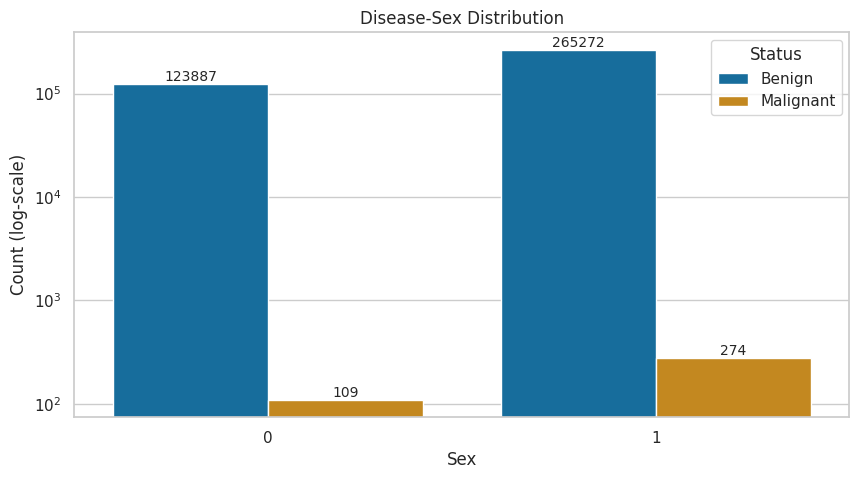

In [16]:
# very large/very small values rep. using log-scale
# resource: https://stackoverflow.com/questions/57722200/how-to-represent-very-large-and-a-very-small-values-in-a-plot
sns.set_theme(style='whitegrid')

fig = plt.figure(figsize=(10,5))
ax = sns.barplot(target_sex_count, x='sex', y='count', hue='status', palette='colorblind', errorbar=None)
ax.set_yscale("log")
_ = ax.set(title='Disease-Sex Distribution',xlabel="Sex", ylabel="Count (log-scale)")

for container in ax.containers:
    ax.bar_label(container, fontsize=10)

ax.legend(title='Status', loc='upper right', labels=['Benign', 'Malignant'])
plt.show()

### 4.2 Age Range Incidence Rates
Note: The Skin Cancer Age Range is an approximation.

Citation/URL: https://www.gentlecure.com/skin-cancer-age-range/#:~:text=Although%20patients%20older%20than%2075,by%20the%20age%20of%2070.

In [17]:
def checkAgeRange(age):
    age = int(age)
    beg_digit = age - 5
    last_digit = age - 1
    return (f"{beg_digit}-{last_digit}")

In [18]:
# Evidence — Based on this data there is weak evidence suggesting adults past 50 y/o
# are more likely to develop skin cancer.

target_age_approx = train_metadata.groupby(['target', 'age_approx']).size().to_frame('size').reset_index()
total = target_age_approx['size'].sum()
target_age_approx['percent'] = target_age_approx['size'] / total
target_age_approx['age_range'] = target_age_approx['age_approx'].apply(checkAgeRange)

In [19]:
# target_age_approx

In [20]:
benign = target_age_approx.loc[target_age_approx['target']==0]
malignant = target_age_approx.loc[target_age_approx['target']==1]

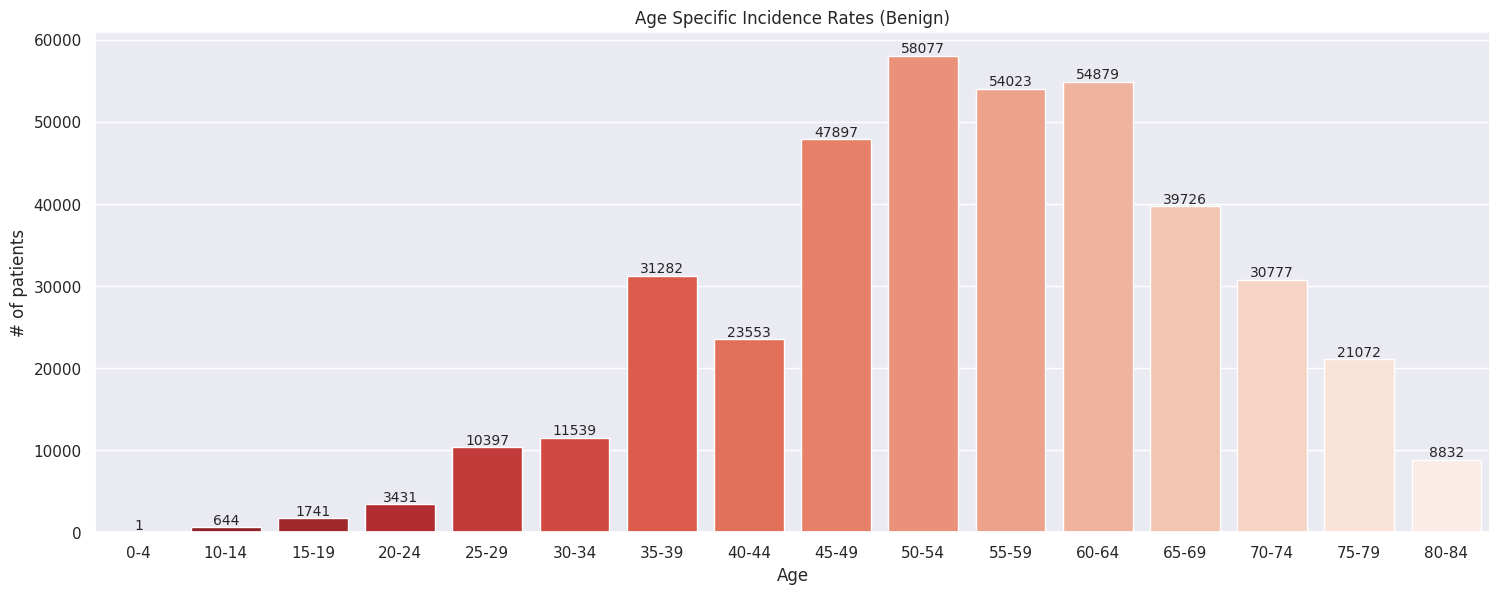

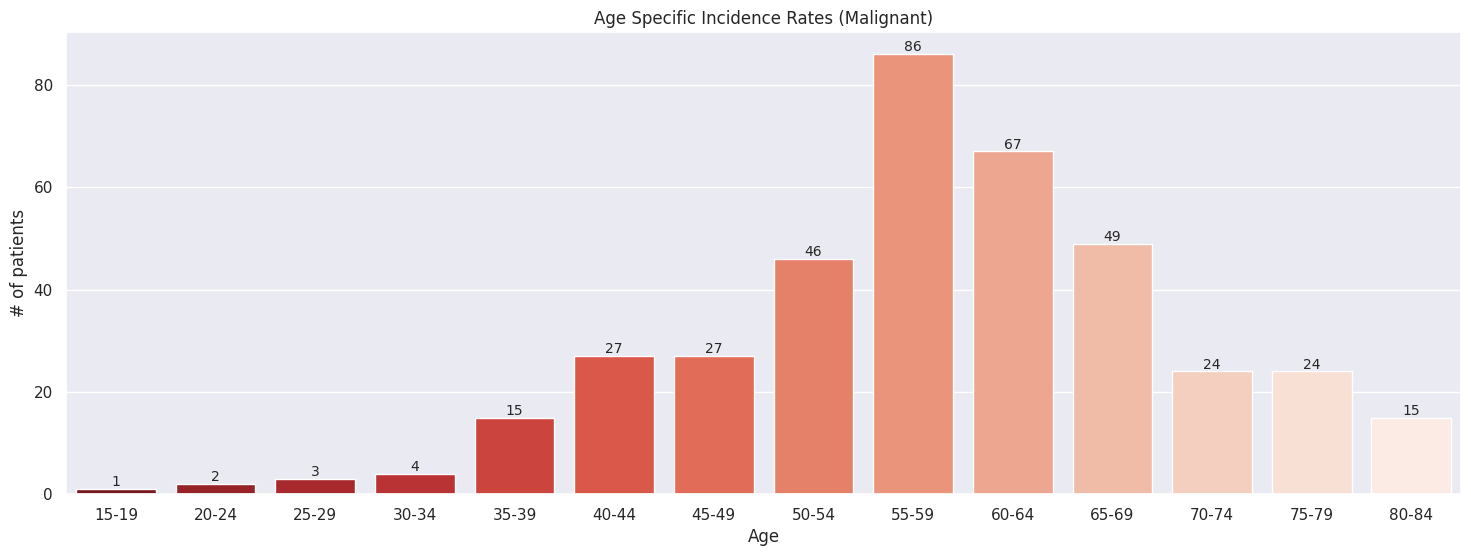

In [21]:
sns.set_theme(style='darkgrid')

# Benign
fig = plt.figure(figsize=(18, 6.5))
ax = sns.barplot(benign, x='age_range', y='size', palette='Reds_r', errorbar='ci')
_ = ax.set(title="Age Specific Incidence Rates (Benign)", xlabel='Age', ylabel='# of patients')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

# Malignant
fig = plt.figure(figsize=(18, 6))
ax = sns.barplot(malignant, x='age_range', y='size', palette='Reds_r', errorbar='ci')
_ = ax.set(title="Age Specific Incidence Rates (Malignant)", xlabel='Age', ylabel='# of patients')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

plt.show()

Notes: Look at age range 35-39. consider if the following drop in 40-44 is significant. let us consider how this service would benefit patients in preventive care and triage those who are in at risk. The above barplot showcases the confidence intervals for

In [22]:
train_metadata['age_range_under50'] = None
train_metadata.loc[train_metadata['age_approx']<50, 'age_range_under50'] = True
train_metadata.loc[train_metadata['age_approx']>50, 'age_range_under50'] = False
train_metadata['age_range_under50'].value_counts()

age_range_under50
False    267697
True      82640
Name: count, dtype: int64

In [23]:
age_range_count = train_metadata.groupby(['target', 'age_range_under50']).size()

In [24]:
age_range_count

target  age_range_under50
0       False                267386
        True                  82588
1       False                   311
        True                     52
dtype: int64

### 4.4 Disease location distribution (Pending)



In [25]:
# benign
fig = plt.figure(figsize=(18,6))
ax = sns.barplot


<Figure size 1800x600 with 0 Axes>

In [26]:
train_metadata['tbp_lv_location'].value_counts().sum()

401059

In [27]:
train_metadata['anatom_site_general'].value_counts().sum()

395303

In [28]:
train_metadata.tbp_lv_location.unique()

array(['Right Leg - Upper', 'Head & Neck', 'Torso Back Top Third',
       'Torso Front Top Half', 'Right Arm - Upper', 'Left Leg - Upper',
       'Torso Front Bottom Half', 'Left Arm - Upper', 'Right Leg',
       'Torso Back Middle Third', 'Right Arm - Lower',
       'Right Leg - Lower', 'Left Leg - Lower', 'Left Arm - Lower',
       'Unknown', 'Left Leg', 'Torso Back Bottom Third', 'Left Arm',
       'Right Arm', 'Torso Front', 'Torso Back'], dtype=object)

In [29]:
train_metadata.anatom_site_general.unique()

array(['lower extremity', 'head/neck', 'posterior torso',
       'anterior torso', 'upper extremity', nan], dtype=object)

### 4.5 Lesion Size & Target (Pending)

In [30]:
train_metadata.clin_size_long_diam_mm.mean()

3.9308271850276397

In [31]:
train_metadata.tbp_lv_areaMM2.min()

0.431600675548883

## 5. Image Processing
- Create a class to load the image dataset
- Load and normalize the images and consider applying transformations (i.e., horizontal, veritical, blur, etc)
- Normalization helps get data within a range and reduces the skewness which helps learn faster and better
- Dataloader (pending)

In [41]:
from torch.utils.data import Dataset
import h5py
from PIL import Image
from io import BytesIO

class SkinCancerDataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None):
    """
    Arguments:
        csv_file (string): Path to the csv with annotations (aka annotations file)
        img_dir (string): Directory with all images.
        transform (callable, optionable): Optional transform to be applied on a sample
    """
    self.metadata = pd.read_csv(csv_file,
                                dtype={'iddx_5': str, 'mel_mitotic_index': str})
    self.isic_ids = self.metadata.isic_id
    self.targets = self.metadata.target
    self.hdf5_file = img_dir
    self.transform = transform

    # Open the hdf5 file during init
    self.hdf5_data = h5py.File(self.hdf5_file,'r+')

  # The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.metadata)

  # Defining the method to get an item from the dataset
  def __getitem__(self, idx):
    img_id = self.isic_ids[idx]
    img_label = self.targets[idx]

    # Access the image data contained in hdf5 file, with the isic_id as key
    img_binary = self.hdf5_data[img_id][()]
    img = Image.open(BytesIO(img_binary)).convert("RGB")

    # Apply transformation (optional) on a sample
    if self.transform:
      sample = self.transform(sample)
      return sample

    return img, img_label

  def __del__(self):
    self.hdf5_data.close()

In [33]:
skin_dataset = SkinCancerDataset(csv_file=train_metadata_path,
                                 img_dir=train_img_path)

# Quick image test
skin_dataset.__getitem__(4)[0]

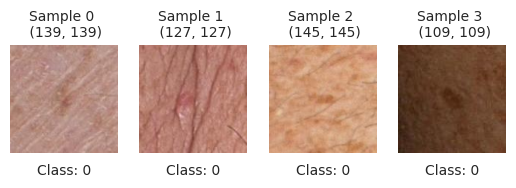

In [112]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(len(skin_dataset)):
    image, label = skin_dataset[i]

    ax = plt.subplot(1, 4, i+1)
    ax.set_title(f"Sample {i} \n {image.size}", fontsize=10)
    ax.text(0.5, -0.1, f"Class: {label}", ha='center',
            va='top', transform=ax.transAxes, fontsize=10)
    plt.tight_layout
    plt.imshow(image)
    ax.set_title
    plt.axis('off')
    if i == 3:
        break

In [ ]:

import torchvision
from torchvision import transforms

In [ ]:
# The images seen are not the same size. Neural Networks generally expect images of a fixed size. Therefore, we will apply normalization
# and some preprocessing code for handling rescaling, random crop, horizontal/vertical flips and possibly examples of blur.


train_transformation = transforms.Compose([
    # resize image
    transformation
])